recapture CellOrbitCorrection.py

In [57]:
import sys

sys.path.append("../")

import copy

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import scipy.optimize

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', "svg")
import matplotlib.colors
import matplotlib.pyplot as plt


from OcelotMinimal.cpbd import elements

from IPython.display import display

In [58]:
from TorchOcelot.Lattice import SIS18_Lattice, SIS18_Cell  # correctors are defined as Hcor
from TorchOcelot.Models import SecondOrderModel

In [59]:
import PlotTrajectory

general properties

In [60]:
dtype = torch.float32
device = torch.device("cpu")

create model

In [61]:
dim = 2
Lattice = SIS18_Lattice

lattice = Lattice()
model = SecondOrderModel(lattice, dim, dtype).to(device)
model.requires_grad_(False)

oldModel = copy.deepcopy(model)

for m in model.maps:
    # add trainable bias to map
    bias = torch.zeros(dim, dtype=dtype)
    m.w1.bias = nn.Parameter(bias, requires_grad=True)


create accelerator

In [62]:
perturbedLattice = Lattice()

for element in perturbedLattice.sequence:
    if type(element) is elements.Quadrupole:
        element.dx = torch.normal(mean=0., std=5e-4, size=(1,)).item()  # same sigma as in TM-PNN

perturbedLattice.update_transfer_maps()

perturbedModel = SecondOrderModel(perturbedLattice, dim, dtype).to(device)
for m in perturbedModel.maps:
    if type(m.element) is elements.Quadrupole:
        # add kick from quadrupole misalignment
        offset = torch.zeros(dim, dtype=dtype)
        offset[0] = m.element.dx

#         kick = torch.matmul((m.w1.weight - torch.eye(dim, dtype=dtype)), offset)  # why -ident?
#         kick = torch.matmul(m.w1.weight, offset)
        kick = torch.tensor([0, m.element.dx], dtype=dtype)

        m.w1.bias = nn.Parameter(kick)

perturbedModel.requires_grad_(False)

SecondOrderModel(
  (maps): ModuleList(
    (0): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (1): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (2): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (3): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (4): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (5): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (6): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (7): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (8): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (9): SecondOrderMap(
      (w1): Linear(in_features=2, out_features=2, bias=False)
    )
    (10): SecondOrderMap(
    

plot initial trajectories

In [63]:
def plotTrajectoriesRefParticle(model, ax):
    refParticle = torch.zeros((1,2), dtype=dtype)
    
    trackRes = model(refParticle, outputPerElement=True).detach().numpy()
    
    ax.plot(model.lattice.endPositions, trackRes[0, 0])
    return

def compareTrajectories(model1, model2, bunch, ax):
    trackRes1 = model1(bunch, outputPerElement=True).detach().numpy()
    trackRes2 = model2(bunch, outputPerElement=True).detach().numpy()
    
    diffX = trackRes1[:, 0, :] - trackRes2[:, 0, :]  # particle, element
    print(diffX.shape)
    
    for particle in diffX:
        ax.plot(model.lattice.endPositions, particle)
    
    return

(1, 372)


Text(0, 0.5, 'initial diff. / m')

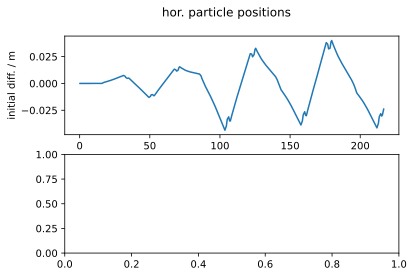

In [64]:
refParticle = torch.zeros((1,2), dtype=dtype)

figTraj, axTraj = plt.subplots(2,1)

compareTrajectories(perturbedModel, model, refParticle, axTraj[0])

figTraj.suptitle("hor. particle positions")

axTraj[0].set_ylabel("initial diff. / m")

plot kick strength diff

In [65]:
def compareKickStrengths(model1, model2, ax):
    model1Kicks, model2Kicks = list(), list()
    
    for m in model1.maps:
        if m.w1.bias is not None:
            model1Kicks.append(m.w1.bias[1].item())
        else:
            model1Kicks.append(0)
    
    for m in model2.maps:
        if m.w1.bias is not None:
            model2Kicks.append(m.w1.bias[1].item())
        else:
            model2Kicks.append(0)
            
    model1Kicks, model2Kicks = np.array(model1Kicks), np.array(model2Kicks)
    
    ax.plot(model1.lattice.positions, model1Kicks - model2Kicks)
    return

Text(0, 0.5, 'before training')

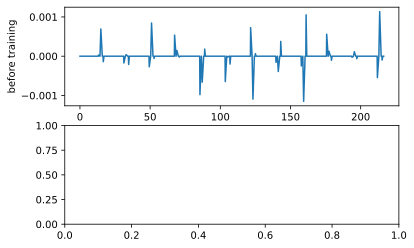

In [66]:
figKick, axKick = plt.subplots(2, 1)

compareKickStrengths(perturbedModel, model, axKick[0])

axKick[0].set_ylabel("before training")

training setup

In [67]:
outputAtBPM = True
xRef = torch.zeros((1,2), dtype=dtype)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, )

refLabel = perturbedModel(xRef, outputAtBPM=outputAtBPM)

fit model to accelerator

In [68]:
# train loop
print("training model")
for epoch in range(300):
    optimizer.zero_grad()

    out = model(xRef, outputAtBPM=outputAtBPM)
    loss = criterion(refLabel, out)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-10)
    optimizer.step()

    if epoch % 10 == 9:
        print("loss: {}".format(loss.item()))

training model
loss: 0.00021641066996380687
loss: 0.00020140840206295252
loss: 0.00018697399355005473
loss: 0.00017310706607531756
loss: 0.00015980718308128417
loss: 0.00014707408263348043
loss: 0.00013490721175912768
loss: 0.0001233058428624645
loss: 0.00011226969218114391
loss: 0.00010179820674238726
loss: 9.189070988213643e-05
loss: 8.254619751824066e-05
loss: 7.376391295110807e-05
loss: 6.554306310135871e-05
loss: 5.7882105465978384e-05
loss: 5.078028698335402e-05
loss: 4.423563586897217e-05
loss: 3.8246413168963045e-05
loss: 3.2810185075504705e-05
loss: 2.792392479022965e-05
loss: 2.358415258640889e-05
loss: 1.9785287804552354e-05
loss: 1.6520598364877515e-05
loss: 1.3779507753497455e-05
loss: 1.1546355381142348e-05
loss: 9.795084224606398e-06
loss: 8.479895768687129e-06
loss: 7.518151960539399e-06
loss: 6.777634553145617e-06
loss: 6.124038918642327e-06


(1, 372)


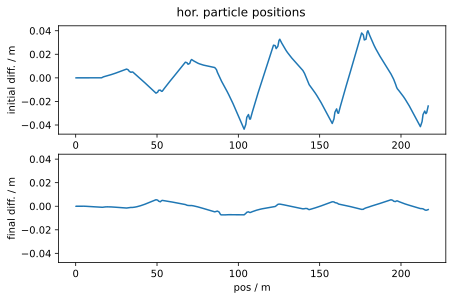

In [69]:
compareTrajectories(perturbedModel, model, refParticle, axTraj[1])

axTraj[1].set_xlabel("pos / m")
axTraj[1].set_ylabel("final diff. / m")

axTraj[1].set_ylim(axTraj[0].get_ylim())

figTraj.tight_layout()
display(figTraj)

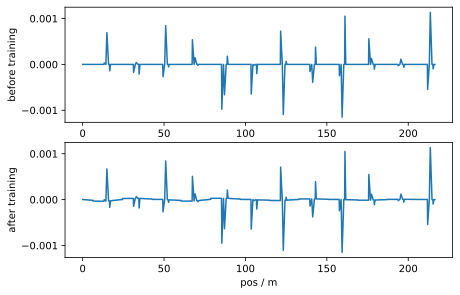

In [70]:
compareKickStrengths(perturbedModel, model, axKick[1])

axKick[1].set_ylim(axKick[0].get_ylim())

axKick[1].set_ylabel("after training")
axKick[1].set_xlabel("pos / m")

figKick.tight_layout()
display(figKick)

"""
************
correct orbits 
************
"""

locate correctors

In [71]:
correctors = list()
for m in model.maps:
    if type(m.element) is elements.Hcor:
        # add bias
        m.w1.bias = nn.Parameter(torch.zeros(dim, dtype=dtype))
        correctors.append(m)

if not correctors:
    print("no correctors present")
    exit()
else:
    print("found {} correctors".format(len(correctors)))

found 24 correctors


In [72]:
def applyCorrectorSettings(settings: np.array):
    # update correctors
    for corrector, kick in zip(correctors, settings):
        corrector.w1.bias[1] = kick

    # observe trajectory
    out = model(xRef, outputAtBPM=outputAtBPM)

    # max orbit deviation
    maxDev = torch.abs(out)[0].max()  # restrict to x-coord
    return maxDev.item()

minimize orbit deviation

In [73]:
print("optimizing corrector settings")
optimRes = scipy.optimize.minimize(applyCorrectorSettings, np.zeros(len(correctors)), tol=1e-6, method="Nelder-Mead",
                                   options={"maxiter": 200, "disp": True, 'fatol': 1e-6, 'xatol': 1e-6})
print(optimRes)

optimizing corrector settings
 final_simplex: (array([[-1.02592870e-04, -2.70925121e-04, -3.46201549e-04,
        -5.71615680e-05,  6.00815660e-04,  3.66715392e-04,
         1.35946614e-04, -4.15632976e-04, -1.58539556e-04,
         5.15819062e-05,  6.13311583e-04,  7.84996047e-04,
         1.36354022e-04, -8.37158378e-04, -2.37079819e-04,
         2.59876074e-04, -1.16879667e-04,  3.68852510e-04,
        -1.94153657e-04, -3.00137222e-04,  1.16442955e-04,
        -4.05872972e-04,  2.86235435e-04,  1.76856244e-04],
       [-1.32228804e-04, -2.74057481e-04, -3.32528871e-04,
        -1.09568751e-04,  5.95662996e-04,  3.57685729e-04,
         2.04991866e-04, -3.53616947e-04, -1.84589210e-04,
         7.17661222e-05,  6.88484116e-04,  7.86129074e-04,
         7.66822577e-05, -9.70265449e-04, -1.21440466e-04,
         2.73577838e-04, -1.10676332e-04,  3.66491208e-04,
        -2.35808213e-04, -2.98827639e-04,  1.46910461e-04,
        -4.01639431e-04,  2.83604638e-04,  1.08370109e-04],
       

In [74]:
for m in model.maps:
    if type(m.element) is elements.Quadrupole:
        print("----")
        print(m.w1.weight.grad)
        print(m.w1.bias.grad)

----
None
tensor([1.0122e-12, 5.9110e-12])
----
None
tensor([-1.5847e-12,  5.5892e-12])
----
None
tensor([4.9539e-13, 6.9792e-12])
----
None
tensor([1.3280e-12, 3.1987e-12])
----
None
tensor([3.8668e-13, 1.5467e-12])
----
None
tensor([7.3187e-13, 1.0002e-12])
----
None
tensor([-2.0180e-12, -7.7924e-12])
----
None
tensor([ 9.9893e-13, -6.0734e-12])
----
None
tensor([-1.0594e-12, -6.7679e-12])
----
None
tensor([-9.5725e-13, -1.9334e-12])
----
None
tensor([-4.8014e-13, -6.4224e-13])
----
None
tensor([-5.3423e-13, -5.4719e-14])
----
None
tensor([1.8383e-12, 6.8864e-12])
----
None
tensor([-7.9527e-13,  5.2633e-12])
----
None
tensor([9.6887e-13, 5.7857e-12])
----
None
tensor([2.0433e-12, 6.3012e-12])
----
None
tensor([-1.5163e-13,  4.1319e-12])
----
None
tensor([1.1013e-12, 4.0086e-12])
----
None
tensor([-3.0622e-13, -2.0976e-12])
----
None
tensor([ 6.4679e-13, -2.0837e-12])
----
None
tensor([-1.4432e-13, -2.6651e-12])
----
None
tensor([-1.3730e-12, -4.4800e-12])
----
None
tensor([ 2.3495e-1

show trajectory of reference particle

Text(0.5, 0, 'pos / m')

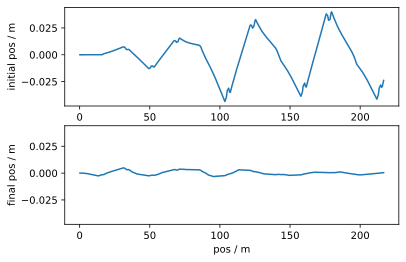

In [75]:
fig, ax = plt.subplots(2,1)

plotTrajectoriesRefParticle(perturbedModel, ax[0])
plotTrajectoriesRefParticle(model, ax[1])

ax[1].set_ylim(ax[0].get_ylim())

ax[0].set_ylabel("initial pos / m")
ax[1].set_ylabel("final pos / m")
ax[1].set_xlabel("pos / m")

apply corrector settings to accelerator

In [76]:
newAccelerator = copy.deepcopy(perturbedModel)

correctors = list()
for m in newAccelerator.maps:
    if type(m.element) is elements.Hcor:
        # add bias
        m.w1.bias = nn.Parameter(torch.zeros(dim, dtype=dtype))
        correctors.append(m)

if not correctors:
    print("no correctors present")
    exit()
else:
    print("found {} correctors".format(len(correctors)))

found 24 correctors


In [77]:
settings = optimRes.x
for corrector, kick in zip(correctors, settings):
        corrector.w1.bias[1] = kick

Text(0, 0.5, 'pos / m')

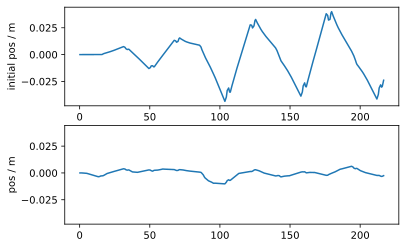

In [78]:
figCorEffect, axCorEffect = plt.subplots(2,1)

plotTrajectoriesRefParticle(perturbedModel, axCorEffect[0])
plotTrajectoriesRefParticle(newAccelerator, axCorEffect[1])

axCorEffect[1].set_ylim(axCorEffect[0].get_ylim())

axCorEffect[0].set_ylabel("initial pos / m")
axCorEffect[1].set_ylabel("final pos / m")
axCorEffect[1].set_ylabel("pos / m")